# Time-Series Forecasting with Deep Learning
This notebook demonstrates how to use LSTM, GRU, and Conv1D+LSTM models to forecast temperature from real-world Delhi weather data.

## 1. Data Loading and Exploration
We begin by importing libraries and loading the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

train_df = pd.read_csv("DailyDelhiClimateTrain.csv")
test_df = pd.read_csv("DailyDelhiClimateTest.csv")

train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

train_df.set_index('date', inplace=True)
test_df.set_index('date', inplace=True)

train_df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


## 2. Data Preprocessing
We normalize the features and create sequences for RNN input.

In [2]:
features = ['humidity', 'wind_speed', 'meanpressure']
target = 'meantemp'

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_train_scaled = feature_scaler.fit_transform(train_df[features])
y_train_scaled = target_scaler.fit_transform(train_df[[target]])

X_test_scaled = feature_scaler.transform(test_df[features])
y_test_scaled = target_scaler.transform(test_df[[target]])

def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(window_size, len(X)):
        Xs.append(X[i-window_size:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

window_size = 30
X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, window_size)
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, window_size)

X_train.shape, y_train.shape

((1432, 30, 3), (1432, 1))

## 3. Model Architecture and Training Function
We define a function to build and train different RNN architectures.

In [3]:
def build_and_train(model_type, X_train, y_train, X_test, y_test):
    model = models.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1], X_train.shape[2])))

    if model_type == 'LSTM':
        model.add(layers.LSTM(64))
    elif model_type == 'GRU':
        model.add(layers.GRU(64))
    elif model_type == 'Conv1D_LSTM':
        model.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
        model.add(layers.MaxPooling1D(pool_size=2))
        model.add(layers.LSTM(64))

    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mae')

    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

    y_pred = model.predict(X_test)
    y_pred_inv = target_scaler.inverse_transform(y_pred)
    y_test_inv = target_scaler.inverse_transform(y_test)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)

    return model, history, mae, y_test_inv, y_pred_inv


## 4. Train and Evaluate All Models
We compare LSTM, GRU, and Conv1D+LSTM models.

In [4]:
results = {}
histories = {}
predictions = {}

for model_type in ['LSTM', 'GRU', 'Conv1D_LSTM']:
    model, history, mae, y_true, y_pred = build_and_train(model_type, X_train, y_train, X_test, y_test)
    results[model_type] = mae
    histories[model_type] = history
    predictions[model_type] = (y_true, y_pred)
    print(f"{model_type} Test MAE: {mae:.3f}")


Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3329 - val_loss: 0.1350
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1403 - val_loss: 0.1394
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1162 - val_loss: 0.1322
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1039 - val_loss: 0.1183
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1019 - val_loss: 0.1321
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1013 - val_loss: 0.1491
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1024 - val_loss: 0.1259
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1073 - val_loss: 0.1451
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0983 - val_loss: 0.1287
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0951 - val_loss: 0.1381
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1022 - val_loss: 0.1444
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1004 - val_lo

## 5. Visualizing Validation Loss

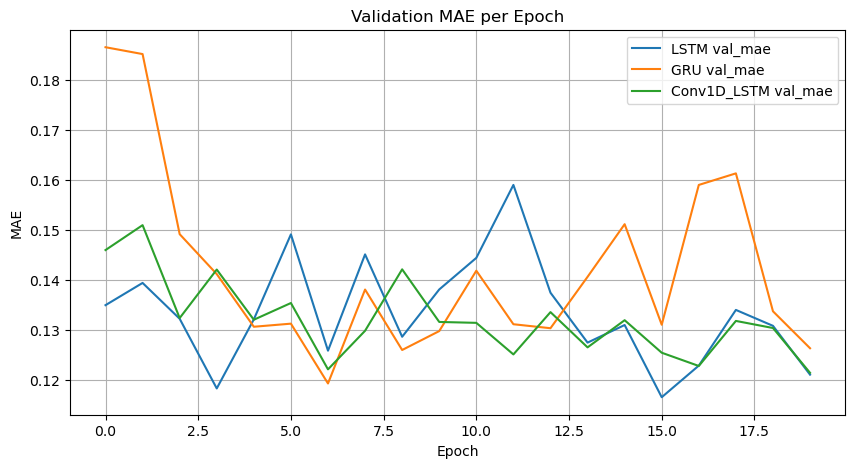

In [5]:
plt.figure(figsize=(10, 5))
for model_type, history in histories.items():
    plt.plot(history.history['val_loss'], label=f"{model_type} val_mae")
plt.title("Validation MAE per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.show()


## 6. Comparing Predictions

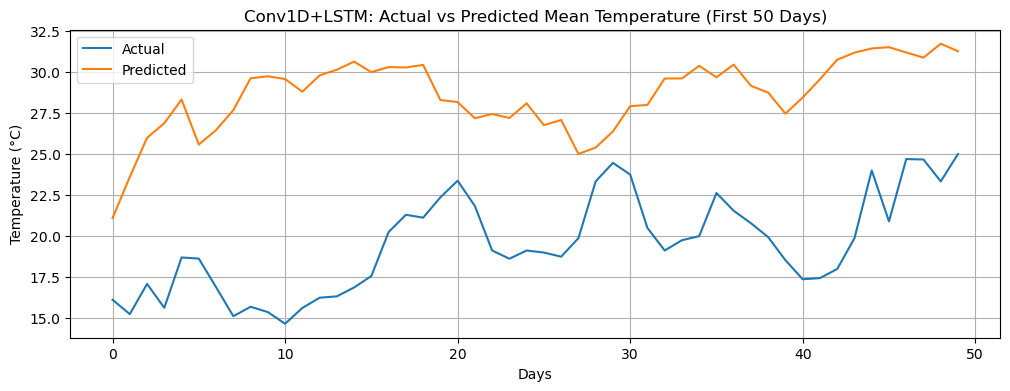

In [6]:
y_true, y_pred = predictions['Conv1D_LSTM']

plt.figure(figsize=(12, 4))
plt.plot(y_true[:50], label='Actual')
plt.plot(y_pred[:50], label='Predicted')
plt.title("Conv1D+LSTM: Actual vs Predicted Mean Temperature (First 50 Days)")
plt.xlabel("Days")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()


## 7. Final Results

In [7]:
import pandas as pd
pd.DataFrame.from_dict(results, orient='index', columns=['Test MAE']).sort_values(by='Test MAE')


,Test MAE
GRU,5.424646
LSTM,6.015489
Conv1D_LSTM,7.075447
